In [1]:
import numpy as np
import sounddevice as sd
import datetime
from scipy.signal import butter, lfilter
from scipy.io import wavfile

def generate_white_noise(duration, sample_rate=44100):
    """
    generate white noise
    to make experiments reproducible, set a seed
    """
    np.random.seed(42)
    white_noise = np.random.randn(int(sample_rate * duration))
    return white_noise

def band_limited_white_noise(low, high, duration, sample_rate=44100):
    """Apply a butterworth filter"""
    white_noise = generate_white_noise(duration, sample_rate)
    nyq = 0.5 * sample_rate
    low = low / nyq
    high = high / nyq
    b, a = butter(5, [low, high], btype='band')
    band_limited = lfilter(b, a, white_noise)
    return band_limited

def pseudo_white_noise(low, high, repetitions, duration, sample_rate=44100):
    """Generate pseudoNoise"""
    # use sinusoidal signal with random phase as pseudo noise
    # t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    # pseudo_noise = np.sin(2 * np.pi * 20 * t + np.random.uniform(0, 2 * np.pi))
    band_limited_noise = band_limited_white_noise(low, high, duration/repetitions)
    pseudo_noise = np.tile(band_limited_noise, repetitions)
    # store the sound signal
    # Format the date and time
    filename = f"pseudoNoise_{low}_{high}.wav"
    wavfile.write(filename, sample_rate, pseudo_noise)
    return pseudo_noise

import numpy as np
import sounddevice as sd

def play_sound(sound, channel, sample_rate=44100):
    """Play the sound on a specified channel (0 or 1)"""
    if sound.ndim == 1:
        # If the sound is mono, duplicate it for both channels
        sound = np.tile(sound[:, np.newaxis], (1, 2))
    
    # Create a stereo sound array with one channel set to zero
    stereo_sound = np.zeros_like(sound)
    
    if channel == 0:
        # Play on left channel
        stereo_sound[:, 0] = sound[:, 0]
    elif channel == 1:
        # Play on right channel
        stereo_sound[:, 1] = sound[:, 1]
    else:
        raise ValueError("Channel must be 0 or 1")
    
    sd.play(stereo_sound, samplerate=sample_rate)
    sd.wait()


In [27]:

# generate and play white noise
# for i in np.arange(10):
duration = 30 # 10s
band_limited_noise = band_limited_white_noise(20, 12000, duration)


In [29]:
# channel 0: left ear, channel 1: right ear 
play_sound(sound = band_limited_noise, channel=0)

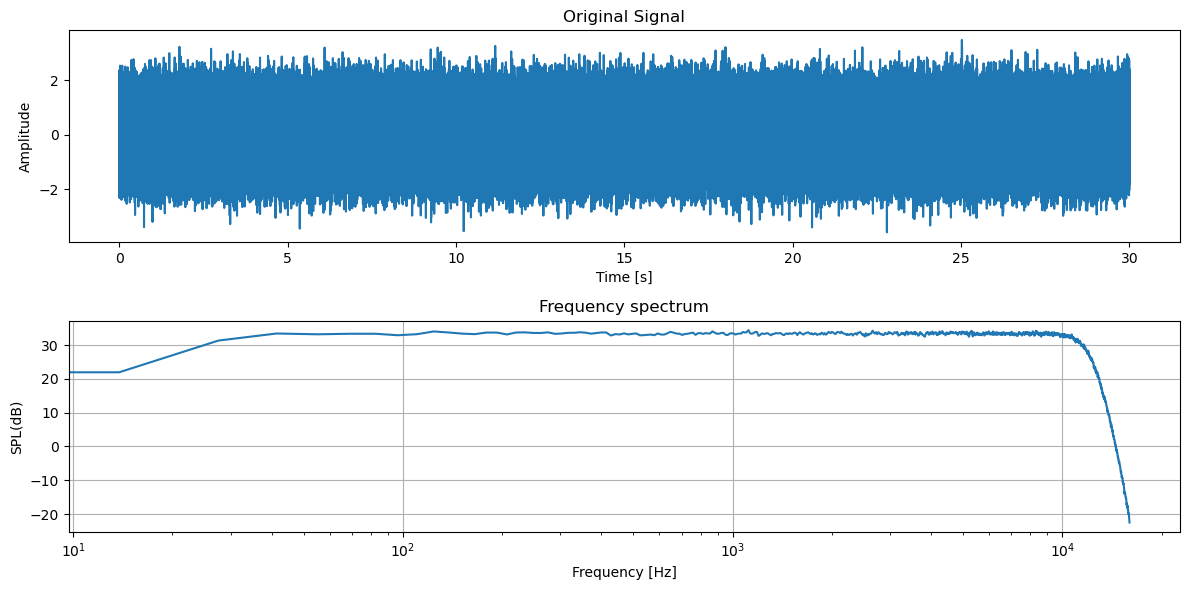

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# parameters：
sample_rate=44100
time_signal = np.arange(0, duration, 1/sample_rate)
data_signal = band_limited_noise

# FFT
frequencies, fft_result = welch(data_signal, fs=sample_rate, scaling='spectrum', nperseg=3200, return_onesided=True)

# choose the frequency range of fft analysis
min_freq = 0
max_freq = 16000
mask = (frequencies >= min_freq) & (frequencies <= max_freq)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_signal, data_signal)
plt.title('Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.semilogx(frequencies[mask],20*np.log10(np.abs(fft_result[mask])/20e-6))
plt.title('Frequency spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('SPL(dB)')
plt.tight_layout()
plt.grid()
plt.show()


In [25]:
# Generate pseudo white noise
repetitions = 5
duration = 10
pseudo_noise = pseudo_white_noise(2000, 4000, repetitions, duration)

In [11]:
# from this block is for the HATs recording
# it will import the .wav file

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.io import wavfile

# select the file
from bf3d_prep import bf3d_data_prep
import numpy as np

recording_prep = bf3d_data_prep(rootfolder = 'Recordings/HATS_recordings', filetype = '.wav')


Dropdown(description='Select:', options=('..', 'HP1-12.8kHz-leftear.wav', 'HP1-leftear-GoodSeal.wav'), value='…

Button(description='Select', style=ButtonStyle())

Output()

In [12]:
# calculate the db spl for specific pa
pa = 10
db_spl = 20 * np.log10(pa / 20e-6)
print(f"The sound pressure level for {pa} Pa is {db_spl} dB SPL")

The sound pressure level for 10 Pa is 113.97940008672037 dB SPL


In [30]:
# create a test sin signal with 1 Pa, 1 kHz, 1 s
sample_rate = 44100
duration = 20
frequency = 1000
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
sin_signal = np.sin(2 * np.pi * frequency * t)


C:\Users\ZHLI\AppData\Local\Temp\ipykernel_24316\935593842.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, hats_t = wavfile.read(recording_prep.selected_file)


The peak value is 72.32550770405736 dB SPL


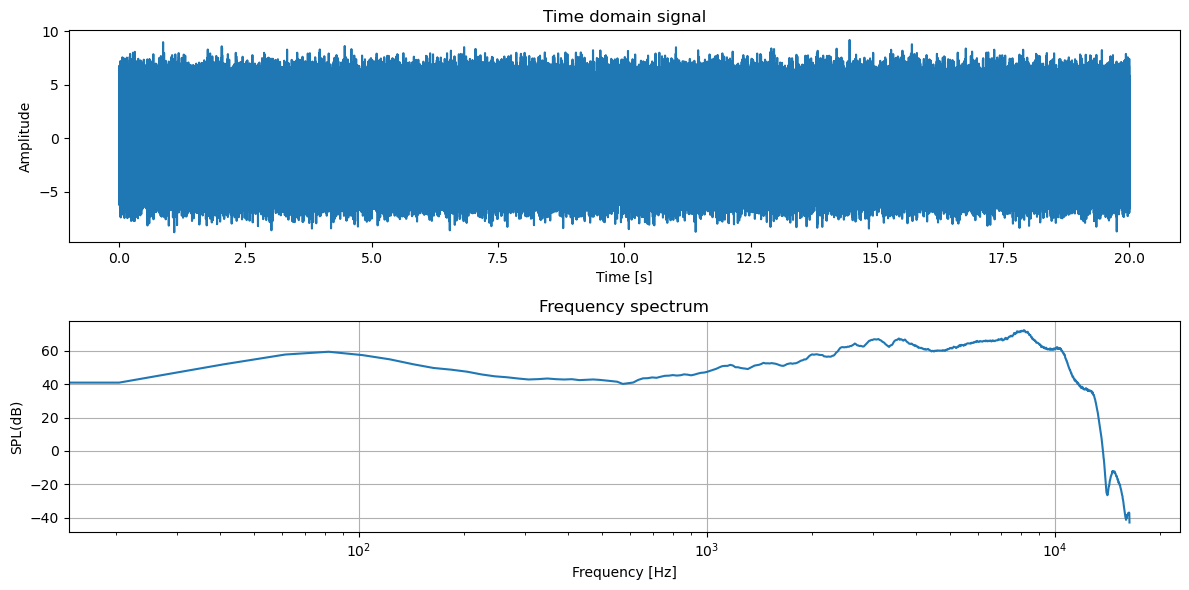

In [70]:
# read the wav file
# get the frequency response by welch method
# 94 dB re 20uPa

sample_rate, hats_t = wavfile.read(recording_prep.selected_file)

#sample_rate = 44100
# hats_t = sin_signal
# the raw wav datas should be converted to pa
# the factor 32767 is the maximum value of the 16-bit integer
# hats_t = hats_t / (2**32/2-1)* 10

time_signal = np.arange(0, len(hats_t)/sample_rate, 1/sample_rate)
data_signal = hats_t / (2**32/2-1)* 10

# FFT
frequencies, fft_result = welch(data_signal, fs=sample_rate, scaling='spectrum', nperseg=1600, return_onesided=True)

# The fft_result is the rms
# fft_result = np.sqrt(2) * fft_result
fft_result = np.sqrt(2) * fft_result

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_signal, data_signal)
plt.title('Time domain signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')


plt.subplot(2, 1, 2)
plt.semilogx(frequencies,20*np.log10(np.abs(fft_result)/20e-6))
plt.title('Frequency spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('SPL(dB)')
plt.tight_layout()
plt.grid()
# get the peak value
peak_value = np.max(20*np.log10(np.abs(fft_result)/20e-6))
print(f"The peak value is {peak_value} dB SPL")
plt.show()



In [72]:
# based on the spectrum I get, revert it, then get a filter
# the filter is used to filter the original signal

# select a high frequency, take a smmoth from there, to make it less sharp
high_freq = 8e3
high_freq_index = np.where(frequencies >= high_freq)[0][0]

# redo the welch to the original signal, but with a lower nperseg after the high frequency
frequencies_high, high_fft_result = welch(data_signal, fs=sample_rate, scaling='spectrum', nperseg=200, return_onesided=True)
hh_index = np.where(frequencies_high >= high_freq)[0][0]

# add the smooth part to the original fft_result
fft_result = np.concatenate(fft_result[:high_freq_index], high_fft_result[hh_index:])

# get the concatenated frequencies
frequencies = np.concatenate((frequencies[:high_freq_index], frequencies_high[hh_index:]))

# select the low frequency, set it as a reference
low_freq = 400

# get the index of the low frequency
low_freq_index = np.where(frequencies >= low_freq)[0][0]

# scale the fft_result, where the low frequency is the reference, should be 0 dB
fft_result_rec = fft_result / fft_result[low_freq_index]

# make all the values below the low frequency to be 1
fft_result_rec[:low_freq_index] = 1

# revert the fft_result
fft_result_rec = np.reciprocal(fft_result_rec)

# get the filter
filter = np.abs(fft_result_rec)

# plot the filter
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.semilogx(frequencies, 20*np.log10(filter))
plt.title('Filter')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(frequencies, 20*np.log10(np.abs(fft_result)/20e-6))
# draw a line at the low frequency
plt.axvline(x=low_freq, color='r', linestyle='--')
plt.title('Original spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('SPL(dB)')
plt.grid()

plt.show()


TypeError: only integer scalar arrays can be converted to a scalar index